### Files
**train/** - the training set files, one npy file per observation; labels are provided in a files shown below   
**test/** - the test set files; you must predict the probability that the observation contains a gravitational wave   
**training_labels.csv** - target values of whether the associated signal contains a gravitational wave   
**sample_submission.csv** - a sample submission file in the correct format

In [1]:
import os
import json
import random
import collections

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def convert_image_id_2_path(image_id: str, is_train: bool = True) -> str:
    folder = "train" if is_train else "test"
    return "../input/g2net-gravitational-wave-detection/{}/{}/{}/{}/{}.npy".format(
        folder, image_id[0], image_id[1], image_id[2], image_id 
    )

In [3]:
train_df = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
train_df

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
...,...,...
559995,ffff9a5645,1
559996,ffffab0c27,0
559997,ffffcf161a,1
559998,ffffd2c403,0


<AxesSubplot:xlabel='target', ylabel='count'>

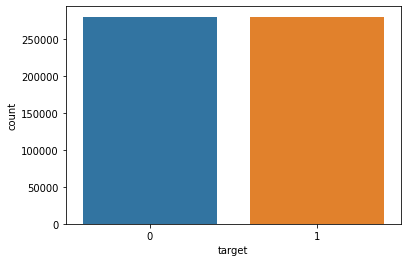

In [4]:
sns.countplot(data=train_df, x="target")

Each data sample (npy file) contains 3 time series (1 for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

In [5]:
def visualize_sample(
    _id, 
    target, 
    colors=("black", "red", "green"), 
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")
):
    path = convert_image_id_2_path(_id)
    x = np.load(path)
    plt.figure(figsize=(16, 7))
    for i in range(3):
        plt.subplot(4, 1, i + 1)
        plt.plot(x[i], color=colors[i])
        plt.legend([signal_names[i]], fontsize=12, loc="lower right")
        
        plt.subplot(4, 1, 4)
        plt.plot(x[i], color=colors[i])
    
    plt.subplot(4, 1, 4)
    plt.legend(signal_names, fontsize=12, loc="lower right")

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

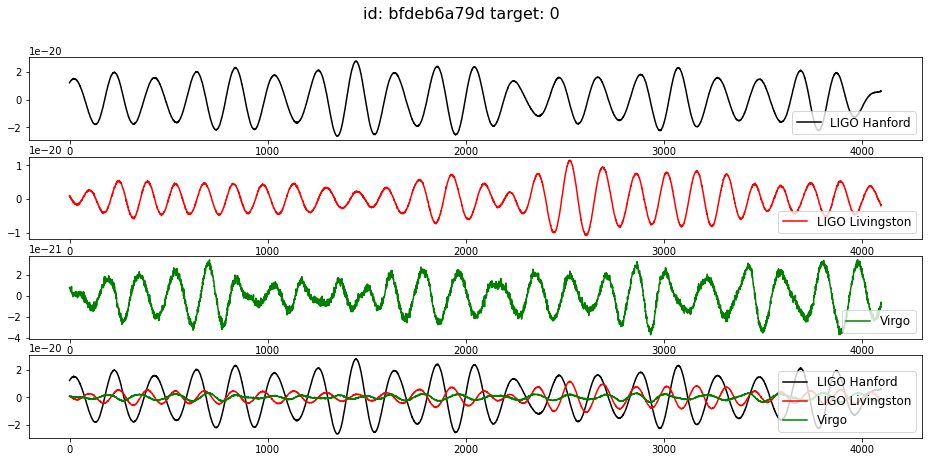

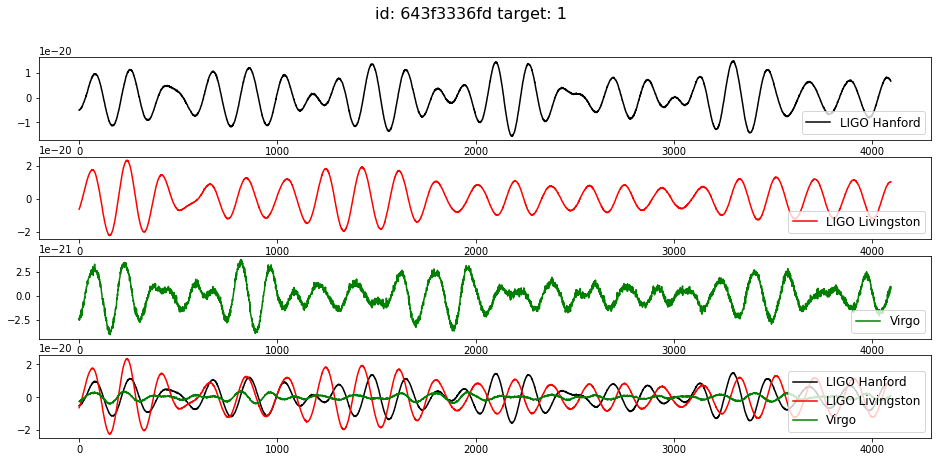

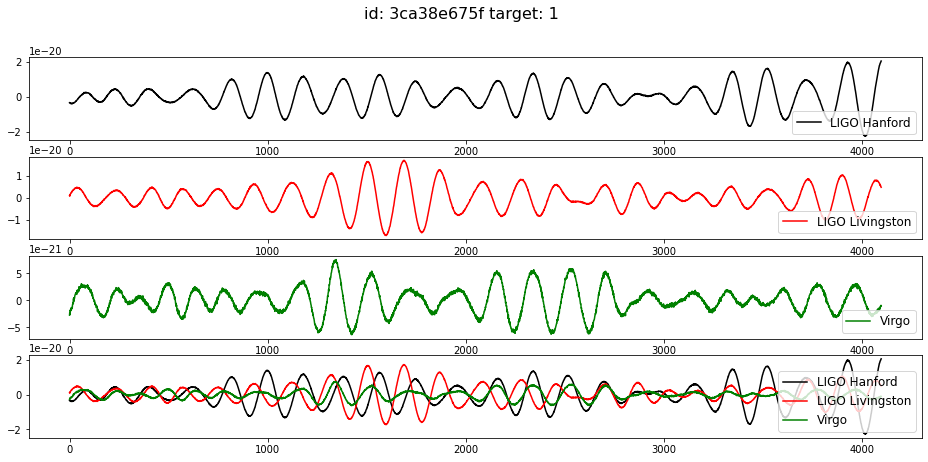

In [6]:
for i in random.sample(train_df.index.tolist(), 3):
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]

    visualize_sample(_id, target)

<a id="3"></a>
<h2 style='background:#1777C4; border:0; color:white'><center>Signal Transformations - Spectogram<center><h2>

In [7]:
import librosa
import librosa.display

In [8]:
def visualize_sample_spectogram(
    _id, 
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")
):
    x = np.load(convert_image_id_2_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        X = librosa.stft(x[i] / x[i].max())
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.subplot(1, 3, i + 1)
        librosa.display.specshow(Xdb, sr=2048, x_axis="time", y_axis="hz", vmin=-30, vmax=50) 
        plt.colorbar()
        plt.title(signal_names[i], fontsize=14)

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

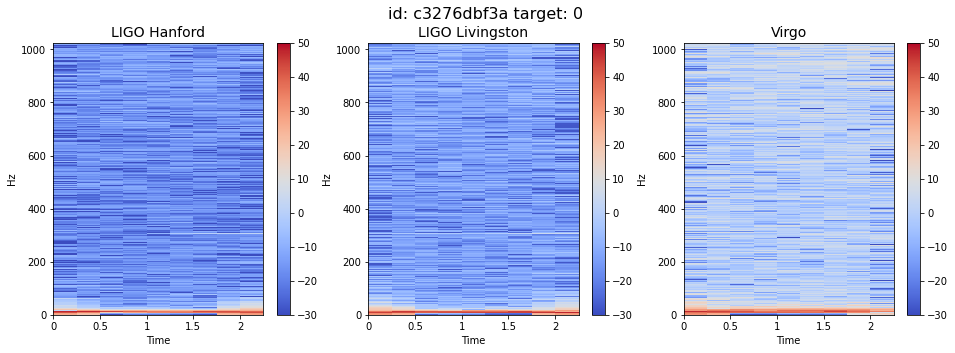

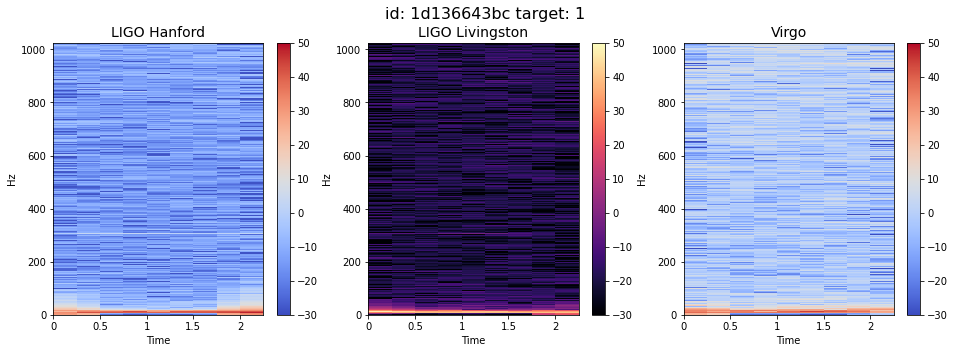

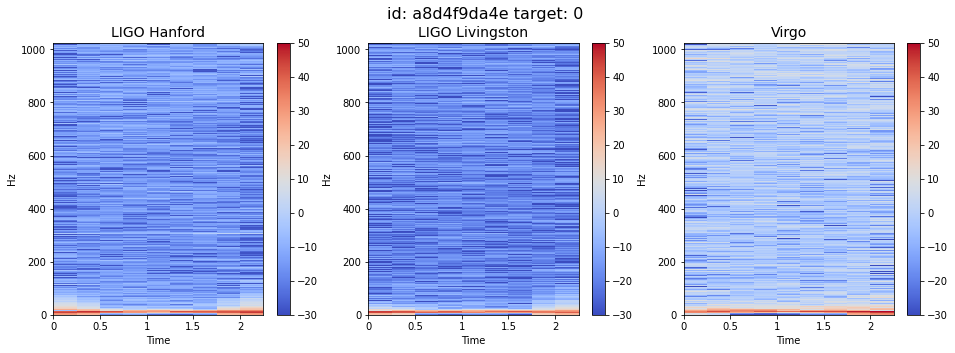

In [9]:
for i in random.sample(train_df.index.tolist(), 3):
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]

    visualize_sample_spectogram(_id, target)

<a id="4"></a>
<h2 style='background:#1777C4; border:0; color:white'><center>Signal Transformations - MFCC<center><h2>

In [10]:
def visualize_sample_mfcc(
    _id, 
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"),
    sr=2048,
):
    x = np.load(convert_image_id_2_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        mfccs = librosa.feature.mfcc(x[i] / x[i].max(), sr=sr)
        plt.subplot(1, 3, i + 1)
        librosa.display.specshow(mfccs, sr=sr, x_axis="time", vmin=-200, vmax=50, cmap="coolwarm")
        plt.title(signal_names[i], fontsize=14)
        plt.colorbar()

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

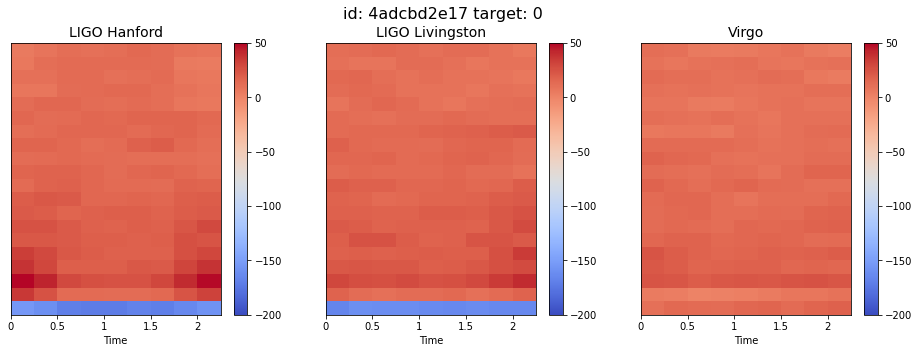

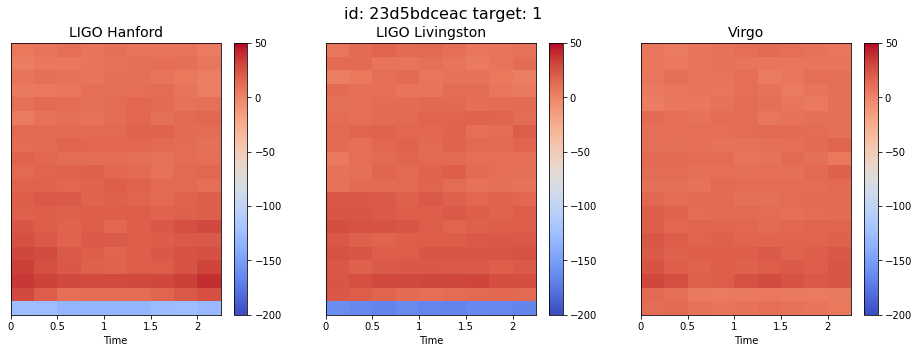

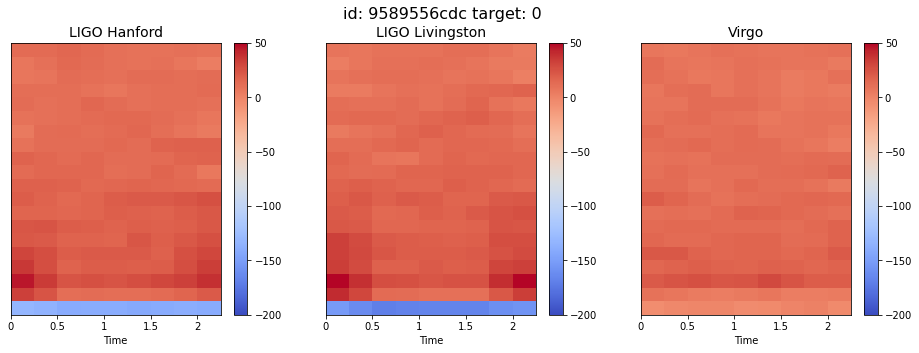

In [11]:
for i in random.sample(train_df.index.tolist(), 3):
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]

    visualize_sample_mfcc(_id, target)

<a id="5"></a>
<h2 style='background:#1777C4; border:0; color:white'><center>Signal Transformations - Q-transform<center><h2>

In [12]:
# !pip install pycbc -qq
# import pycbc.types

In [13]:
!pip install -q nnAudio -qq
import torch
from nnAudio.Spectrogram import CQT1992v2

In [14]:
Q_TRANSFORM = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=32)

def visualize_sample_qtransform(
    _id, 
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"),
    sr=2048,
):
    x = np.load(convert_image_id_2_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        waves = x[i] / np.max(x[i])
        waves = torch.from_numpy(waves).float()
        image = Q_TRANSFORM(waves)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(image.squeeze())
        plt.title(signal_names[i], fontsize=14)

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

CQT kernels created, time used = 0.0309 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


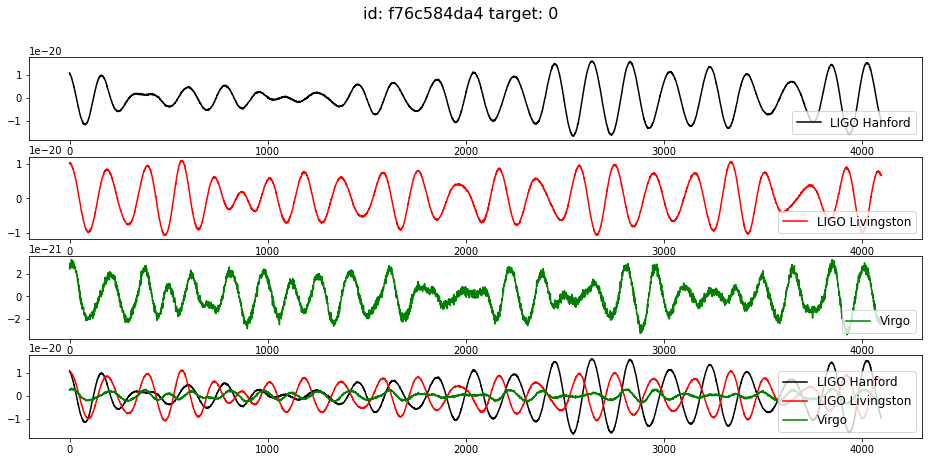

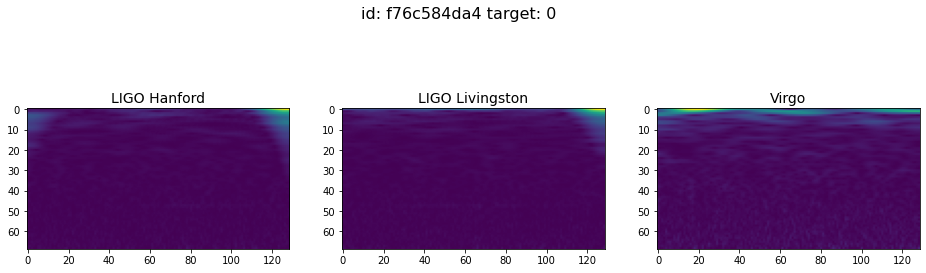

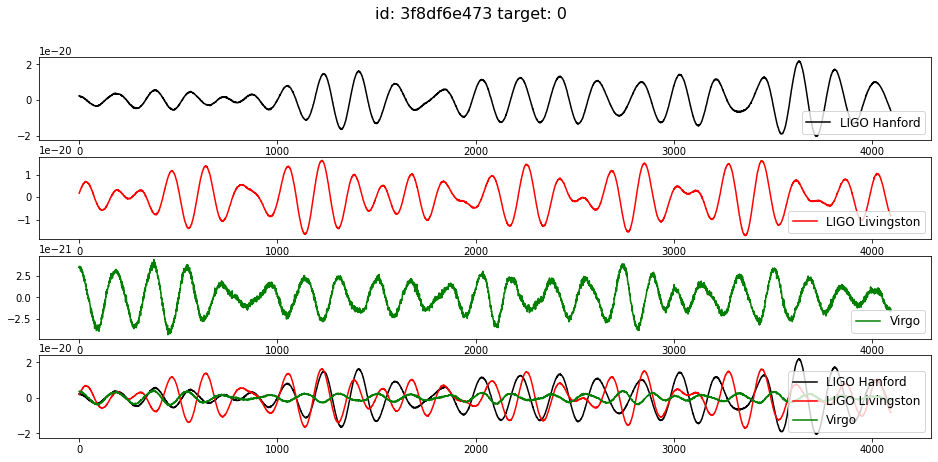

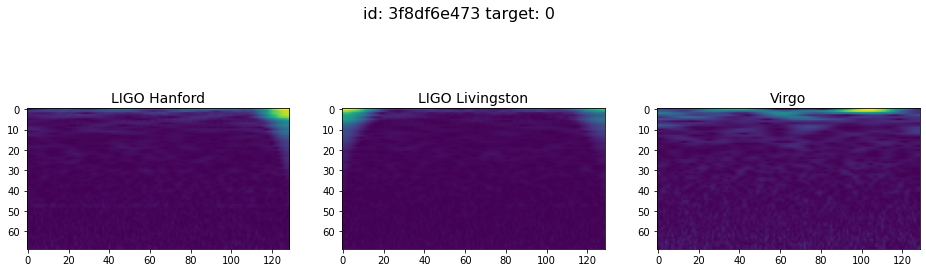

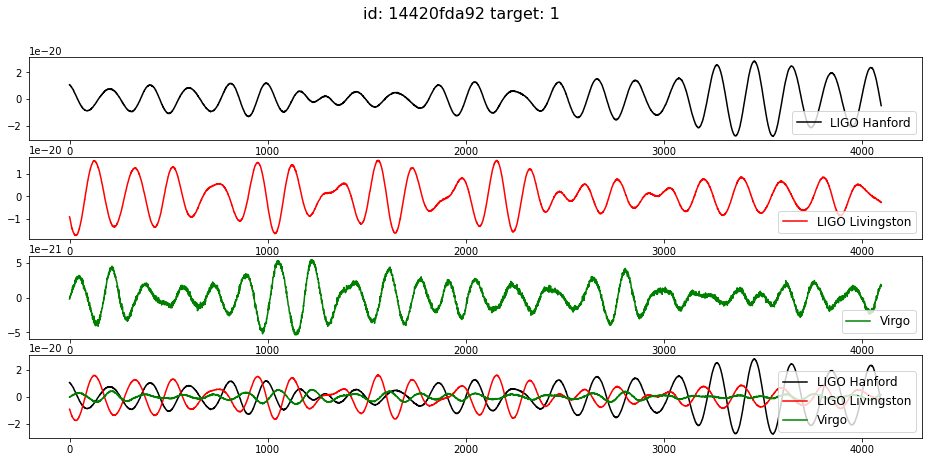

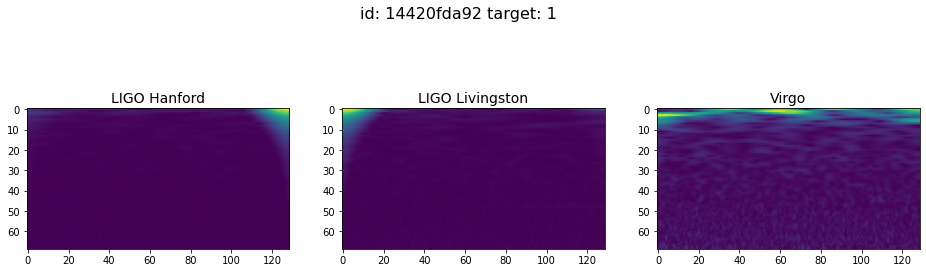

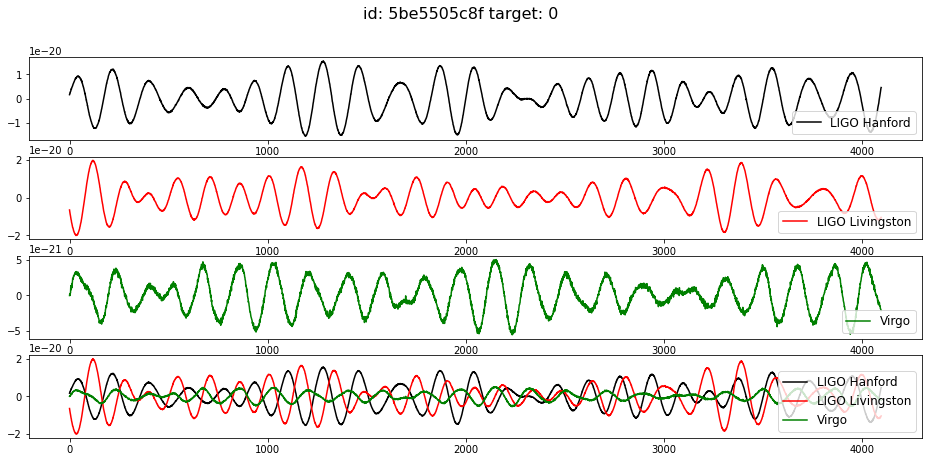

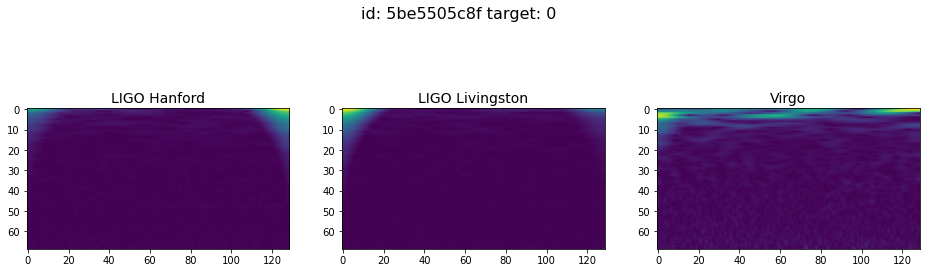

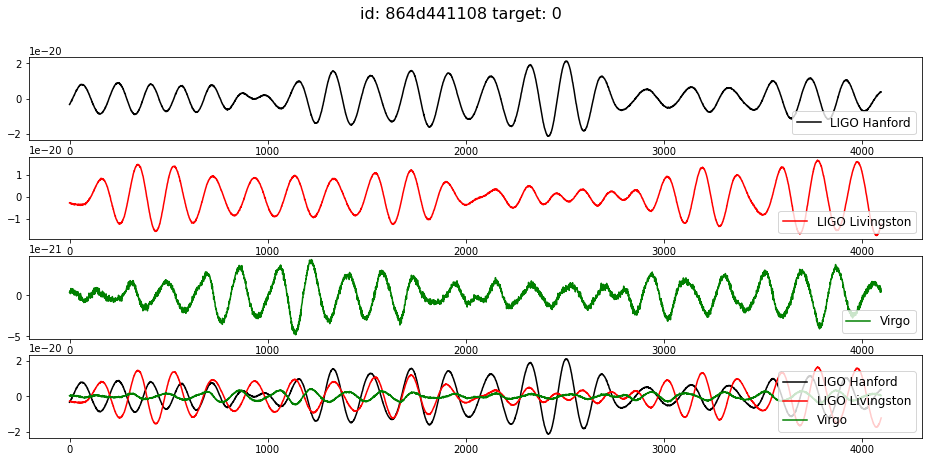

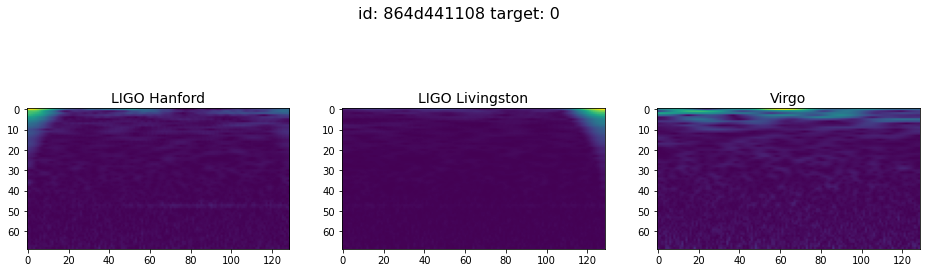

In [15]:
for i in random.sample(train_df.index.tolist(), 5):
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]

    visualize_sample(_id, target)
    visualize_sample_qtransform(_id, target)

<a id="10"></a>
<h2 style='background:#1777C4; border:0; color:white'><center>Competition Metric<center><h2>


Submissions are evaluated on [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) between the predicted probability and the observed target.


In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

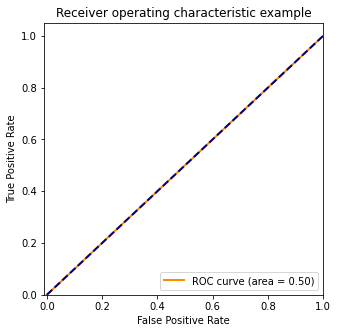

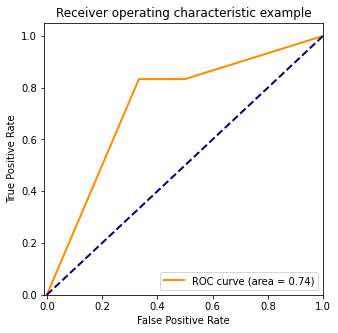

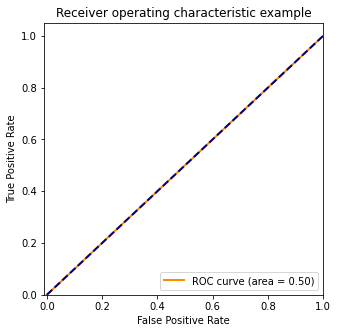

In [17]:
list_y_true = [
    [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.], #  IMBALANCE
]
list_y_pred = [
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.9, 0.9, 0.9, 0.9, 0.1, 0.9, 0.9, 0.1, 0.9, 0.1, 0.1, 0.5],
    [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], #  IMBALANCE
]

for y_true, y_pred in zip(list_y_true, list_y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

<a id="20"></a>
<h2 style='background:#1777C4; border:0; color:white'><center>Sample Submission<center><h2>

In [18]:
submission = pd.read_csv("../input/g2net-gravitational-wave-detection/sample_submission.csv")
submission.to_csv("submission.csv", index=False)

<a id="100"></a>
<h2 style='background:#1777C4; border:0; color:white'><center>Modeling<center><h2>

In [19]:
!pip install efficientnet_pytorch -qq

In [20]:
import time

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
from torch.autograd import Variable
import efficientnet_pytorch
from sklearn.model_selection import StratifiedKFold

In [21]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


set_seed(42)

In [22]:
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths, targets):
        self.paths = paths
        self.targets = targets
        
        self.q_transform = CQT1992v2(
            sr=2048, fmin=20, fmax=1024, hop_length=32
        )
          
    def __len__(self):
        return len(self.paths)
    
    def __get_qtransform(self, x):
        image = []
        for i in range(3):
            waves = x[i] / np.max(x[i])
            waves = torch.from_numpy(waves).float()
            channel = self.q_transform(waves).squeeze().numpy()
            image.append(channel)
            
        return torch.tensor(image).float()
    
    def __getitem__(self, index):
        file_path = convert_image_id_2_path(self.paths[index])
        x = np.load(file_path)
        image = self.__get_qtransform(x)
        
        y = torch.tensor(self.targets[index], dtype=torch.float)
            
        return {"X": image, "y": y}

In [23]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = efficientnet_pytorch.EfficientNet.from_pretrained("efficientnet-b7")
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out

In [24]:
class LossMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0

    def update(self, val):
        self.n += 1
        # incremental update
        self.avg = val / self.n + (self.n - 1) / self.n * self.avg

        
class AccMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().astype(int)
        y_pred = y_pred.cpu().numpy() >= 0
        last_n = self.n
        self.n += len(y_true)
        true_count = np.sum(y_true == y_pred)
        # incremental update
        self.avg = true_count / self.n + last_n / self.n * self.avg

In [25]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        loss_meter, 
        score_meter
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss_meter = loss_meter
        self.score_meter = score_meter
        
        self.best_valid_score = -np.inf
        self.n_patience = 0
        
        self.messages = {
            "epoch": "[Epoch {}: {}] loss: {:.5f}, score: {:.5f}, time: {} s",
            "checkpoint": "The score improved from {:.5f} to {:.5f}. Save model to '{}'",
            "patience": "\nValid score didn't improve last {} epochs."
        }
    
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_score, train_time = self.train_epoch(train_loader)
            valid_loss, valid_score, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                self.messages["epoch"], "Train", n_epoch, train_loss, train_score, train_time
            )
            
            self.info_message(
                self.messages["epoch"], "Valid", n_epoch, valid_loss, valid_score, valid_time
            )

            if True:
#             if self.best_valid_score < valid_score:
                self.info_message(
                    self.messages["checkpoint"], self.best_valid_score, valid_score, save_path
                )
                self.best_valid_score = valid_score
                self.save_model(n_epoch, save_path)
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message(self.messages["patience"], patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        train_loss = self.loss_meter()
        train_score = self.score_meter()
        
        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            train_loss.update(loss.detach().item())
            train_score.update(targets, outputs.detach())

            self.optimizer.step()
            
            _loss, _score = train_loss.avg, train_score.avg
            message = 'Train Step {}/{}, train_loss: {:.5f}, train_score: {:.5f}'
            self.info_message(message, step, len(train_loader), _loss, _score, end="\r")
        
        return train_loss.avg, train_score.avg, int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        valid_loss = self.loss_meter()
        valid_score = self.score_meter()

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                valid_loss.update(loss.detach().item())
                valid_score.update(targets, outputs)
                
            _loss, _score = valid_loss.avg, valid_score.avg
            message = 'Valid Step {}/{}, valid_loss: {:.5f}, valid_score: {:.5f}'
            self.info_message(message, step, len(valid_loader), _loss, _score, end="\r")
        
        return valid_loss.avg, valid_score.avg, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            save_path,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


skf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
for fold, (train_index, valid_index) in enumerate(skf.split(train_df, train_df["target"])):
    train_X = train_df.iloc[train_index]
    valid_X = train_df.iloc[valid_index][:20000] # Reduce calculation time
    print(train_X.shape, valid_X.shape)

    train_data_retriever = DataRetriever(
        train_X["id"].values, 
        train_X["target"].values, 
    )

    valid_data_retriever = DataRetriever(
        valid_X["id"].values, 
        valid_X["target"].values,
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=32,
        shuffle=True,
        num_workers=8,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=32,
        shuffle=False,
        num_workers=8,
    )

    model = Model()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion, 
        LossMeter, 
        AccMeter
    )

    history = trainer.fit(
        1, 
        train_loader, 
        valid_loader, 
        f"best-model-{fold}.pth", 
        100,
    )

(280000, 2) (20000, 2)
CQT kernels created, time used = 0.0154 seconds
CQT kernels created, time used = 0.0145 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7
EPOCH: 1
[Epoch Train: 1] loss: 0.45706, score: 0.77556, time: 7487 s
[Epoch Valid: 1] loss: 0.52131, score: 0.72640, time: 341 s
The score improved from -inf to 0.72640. Save model to 'best-model-0.pth'
(280000, 2) (20000, 2)
CQT kernels created, time used = 0.0298 seconds
CQT kernels created, time used = 0.0146 seconds
Loaded pretrained weights for efficientnet-b7
EPOCH: 1
[Epoch Train: 1] loss: 0.45649, score: 0.77570, time: 7670 s
[Epoch Valid: 1] loss: 0.43005, score: 0.78985, time: 345 s
The score improved from -inf to 0.78985. Save model to 'best-model-1.pth'


In [27]:
models = []
for i in range(2):
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(f"best-model-{i}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    models.append(model)

Loaded pretrained weights for efficientnet-b7
Loaded pretrained weights for efficientnet-b7


In [28]:
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths):
        self.paths = paths

        self.q_transform = CQT1992v2(
            sr=2048, fmin=20, fmax=1024, hop_length=32
        )
          
    def __len__(self):
        return len(self.paths)
    
    def __get_qtransform(self, x):
        image = []
        for i in range(3):
            waves = x[i] / np.max(x[i])
            waves = torch.from_numpy(waves).float()
            channel = self.q_transform(waves).squeeze().numpy()
            image.append(channel)
            
        return torch.tensor(image).float()
    
    def __getitem__(self, index):
        file_path = convert_image_id_2_path(self.paths[index], is_train=False)
        x = np.load(file_path)
        image = self.__get_qtransform(x)
            
        return {"X": image, "id": self.paths[index]}

In [29]:
test_data_retriever = DataRetriever(
    submission["id"].values, 
)

test_loader = torch_data.DataLoader(
    test_data_retriever,
    batch_size=32,
    shuffle=False,
    num_workers=8,
)

CQT kernels created, time used = 0.0347 seconds


In [30]:
y_pred = []
ids = []

for e, batch in enumerate(test_loader):
    print(f"{e}/{len(test_loader)}", end="\r")
    with torch.no_grad():
        tmp_pred = np.zeros((batch["X"].shape[0], ))
        for model in models:
            tmp_res = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            tmp_pred += tmp_res / 2
        y_pred.extend(tmp_pred)
        ids.extend(batch["id"])

In [31]:
submission = pd.DataFrame({"id": ids, "target": y_pred})
submission.to_csv("model_submission.csv", index=False)

In [32]:
submission

,id,target
0,00005bced6,0.999489
1,0000806717,0.871162
2,0000ef4fe1,0.377938
3,00020de251,0.674378
4,00024887b5,0.214219
...,...,...
225995,ffff4125f1,0.406821
225996,ffff9d32a6,0.317883
225997,ffff9f4c1f,0.269476
225998,ffffa19693,0.998969


### WORK IN PROGRESS ...